# Webscraping from LA County COVID-19 Site and Creating Plot
- Patty Jula, <pattyjula@gmail.com>

LA County Public Health has been providing daily counts of the number of cases and rates Los Angeles County from COVID-19. This script provides a way to download the day's counts, load to a database, in this case a CSV, and create a plot. 

Source: <http://publichealth.lacounty.gov/media/Coronavirus/locations.htm>
## Note:
This type of webscraping is only available from sites that reveal their source code. The best practice is to ask permission before scraping so an organization's servers are not overloaded.

In [115]:
# Dependencies
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams

In [116]:
# Boilerplate code
url = 'http://publichealth.lacounty.gov/media/Coronavirus/locations.htm'
res = requests.get(url)
html_page = res.content

roundup_next_pow_10 = lambda x: 10**(
    int(np.log(x)/np.log(10)) + 1)

## Parse through the html

In [117]:
soup = BeautifulSoup(html_page, 'html.parser')
#print(soup.prettify())


## Load data to a Pandas dataframe

In [118]:
# column names
column = ['location', 'count', 'rate']

# empty list
data = []
count = 0
table = soup.find("table", {"table table-striped table-bordered table-sm"})#.findAll('tr')
for element in table.findAll("tr"):
    count += 1
    if count > 29: # first 29 rows are not needed
        # find cells containing td
        cells = element.findAll("td")
        info = [cell.text for cell in cells] # get the cell text
        data.append(info) # append to data list


In [119]:
df = pd.DataFrame(data, columns= column,) # convert to dataframe
df = df[df.rate != '--'] # drop select records
#df.to_csv("county.csv", encoding='utf-8', index=False)

In [120]:
# handle empty cells, they are not read as NaN by default
df['rate'].replace('', np.nan, inplace=True)
# now they can be deleted
df.dropna(subset=['rate'], inplace=True)

In [121]:
df.to_csv("county.csv", encoding='utf-8', index=False)
df = pd.read_csv('county.csv', index_col=False)
#df.to_csv("county.csv", encoding='utf-8', index=False)
df=df[df['location'].apply(lambda x: x.startswith('Los Angeles -'))]
df.rate.astype(float)
df = df.sort_values(by='rate',ascending=False)

df.head(50)

,location,count,rate
114,Los Angeles - Hancock Park,37,225.27
83,Los Angeles - Beverly Crest,24,193.63
82,Los Angeles - Bel Air,15,182.53
89,Los Angeles - Carthay,24,178.86
98,Los Angeles - Crestview,20,174.73
91,Los Angeles - Century City,21,173.38
136,Los Angeles - Melrose,129,166.16
158,Los Angeles - South Carthay,17,160.44
131,Los Angeles - Little Armenia,12,158.52
86,Los Angeles - Brentwood,46,147.12


## Add today's date to the dataframe

In [122]:
import datetime
def today_date():
    '''
    utils:
    get the datetime of today
    '''
    date=datetime.datetime.now().date()
    date=pd.to_datetime(date)
    return date
df['Date'] = today_date()

## foo

# bar

## Explicitly convert Dat field to date

In [123]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
#df2['count'] = d2['count'].str.replace(',', '').astype(int)
df['location'] = df.location.str[14:]
df.head() 


,location,count,rate,Date
114,Hancock Park,37,225.27,2020-04-05
83,Beverly Crest,24,193.63,2020-04-05
82,Bel Air,15,182.53,2020-04-05
89,Carthay,24,178.86,2020-04-05
98,Crestview,20,174.73,2020-04-05


In [124]:
df.to_csv("nbhrd_temp.csv", encoding='utf-8', index=False)
df.head()

,location,count,rate,Date
114,Hancock Park,37,225.27,2020-04-05
83,Beverly Crest,24,193.63,2020-04-05
82,Bel Air,15,182.53,2020-04-05
89,Carthay,24,178.86,2020-04-05
98,Crestview,20,174.73,2020-04-05


## Now let's deal with the existing database

### This existing database contains previous day's data

In [125]:
dfDB = pd.read_csv("neighborhood_storage.csv", parse_dates=['Date'], dayfirst=True)
#dfDB.set_index('Date')
#dfDB.head()

## If current day's date is already in database, delete it

In [126]:
for index, row in dfDB.iterrows():
    #print(row['Date'])
    if row['Date'] == today_date():
        #print('Found')
        dfDB.drop(index, inplace=True)
    else:
        pass

## Then let's add the newly scraped data to the database

In [127]:
df= dfDB.append(df, ignore_index = True,sort=True)
df['Date'] = pd.to_datetime(df['Date']).dt.date
#df = df.sort_values(by='Date',ascending=True)
#del df['Unnamed: 0']
#df['Date'] = pd.to_datetime(df['Date']).dt.date
print('rate: per 100,000')
df.head(20)

rate: per 100,000


,Date,count,location,rate
0,2020-04-04,37,Hancock Park,225.27
1,2020-04-04,24,Beverly Crest,193.63
2,2020-04-04,15,Bel Air,182.53
3,2020-04-04,24,Carthay,178.86
4,2020-04-04,20,Crestview,174.73
5,2020-04-04,21,Century City,173.38
6,2020-04-04,129,Melrose,166.16
7,2020-04-04,17,South Carthay,160.44
8,2020-04-04,12,Little Armenia,158.52
9,2020-04-04,46,Brentwood,147.12


In [128]:


#df.to_csv("neighborhood_storage.csv", encoding='utf-8', index=False)
df.head()

,Date,count,location,rate
0,2020-04-04,37,Hancock Park,225.27
1,2020-04-04,24,Beverly Crest,193.63
2,2020-04-04,15,Bel Air,182.53
3,2020-04-04,24,Carthay,178.86
4,2020-04-04,20,Crestview,174.73


## Again, explicitly set date

In [129]:
#df['Date'] = df["Date"].apply(pd.to_datetime,format='%Y-%m-%d')
df['Date'] = pd.to_datetime(df['Date']).dt.date
#df = df.sort_values('Date').nlargest(10, 'rate')
df2 = df.nlargest(10, ['rate']) 

df2.head(20)

,Date,count,location,rate
0,2020-04-04,37,Hancock Park,225.27
120,2020-04-05,37,Hancock Park,225.27
1,2020-04-04,24,Beverly Crest,193.63
121,2020-04-05,24,Beverly Crest,193.63
2,2020-04-04,15,Bel Air,182.53
122,2020-04-05,15,Bel Air,182.53
3,2020-04-04,24,Carthay,178.86
123,2020-04-05,24,Carthay,178.86
4,2020-04-04,20,Crestview,174.73
124,2020-04-05,20,Crestview,174.73


# Create plot with seaborn

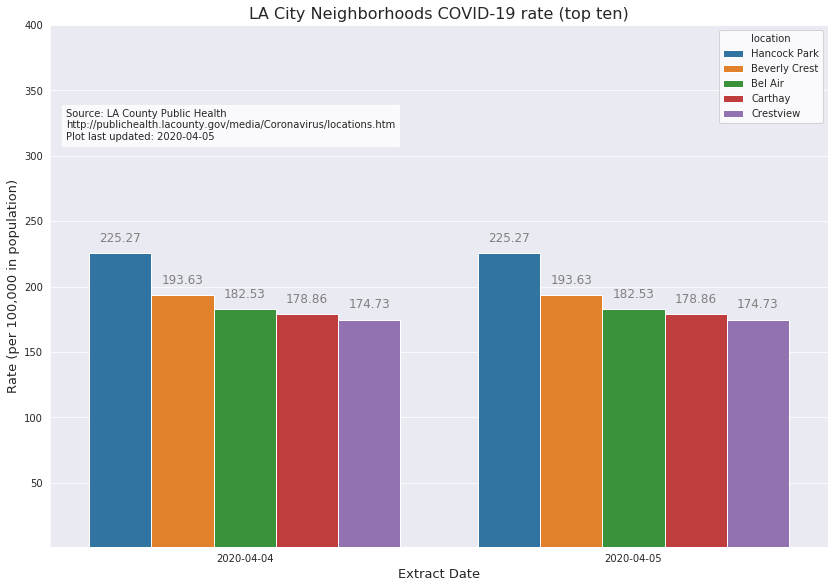

In [140]:
#sns.set(style="whitegrid")
sns.set_style('darkgrid')
fig, ax = plt.subplots()
rcParams['figure.figsize'] = 11.7,8.27
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
rcParams['figure.figsize'] = 11.7,8.27
sns.barplot(x="Date", y="rate", hue= 'location', data=df2)#,hue_order=pd.value_counts(df['rate']).iloc[:10])#, palette ="bright")#, color= 'Set2')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
# Annotate bars
for p in ax.patches:
    #y = int("count")
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='center', fontsize=12, color='gray', xytext=(0, 15),
        textcoords='offset points')
#sns.set_ylabels("") 
plt.xlabel("Extract Date", size = 13)
plt.ylabel("Rate (per 100,000 in population)", size = 13)
#plt.yscale('log')
plt.title("LA City Neighborhoods COVID-19 rate (top ten)", size = 16)
# bar lot
plt.ylim(1,400)
plt.tight_layout()
source_txt = """Source: LA County Public Health
http://publichealth.lacounty.gov/media/Coronavirus/locations.htm
Plot last updated: """
last_date = df2["Date"].max()
source_txt += last_date.strftime("%Y-%m-%d")
plt.figtext(0.02, 0.78, source_txt,transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.8))
, horizontalalignment='right') 
plt.savefig('neighborhood.png', dpi=400) 
plt.show()

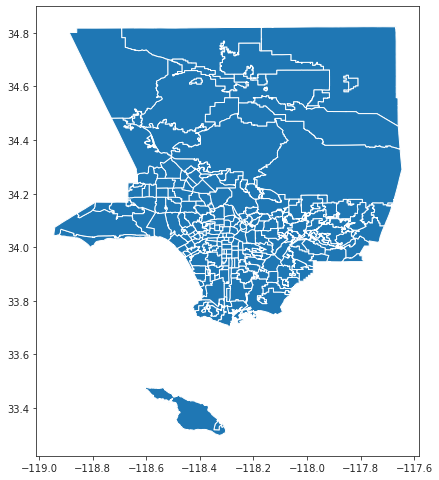

In [131]:
import geopandas
#url = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-current.geojson"
gdf = geopandas.read_file("./nghbrhdraw.shp")
gdf.plot()
#gdf2 = gdf
#gdf2.to_file(driver = 'ESRI Shapefile', filename= './nghbrhdraw.shp')

In [132]:
#pip install geopandas
#gdf.to_csv("neighborhoods.csv")
gdf.head()


,kind,external_i,name,slug,set,metadata,resource_u,geometry
0,L.A. County Neighborhood (Current),acton,Acton,acton-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 39.3391089485, ""type"": ""unincorporate...",/1.0/boundary/acton-la-county-neighborhood-cur...,"POLYGON ((-118.20262 34.53899, -118.18947 34.5..."
1,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,adams-normandie-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 0.805350187789, ""type"": ""segment-of-a...",/1.0/boundary/adams-normandie-la-county-neighb...,"POLYGON ((-118.30901 34.03741, -118.30041 34.0..."
2,L.A. County Neighborhood (Current),agoura-hills,Agoura Hills,agoura-hills-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 8.14676029818, ""type"": ""standalone-ci...",/1.0/boundary/agoura-hills-la-county-neighborh...,"POLYGON ((-118.76193 34.16820, -118.72632 34.1..."
3,L.A. County Neighborhood (Current),agua-dulce,Agua Dulce,agua-dulce-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 31.4626319451, ""type"": ""unincorporate...",/1.0/boundary/agua-dulce-la-county-neighborhoo...,"POLYGON ((-118.25468 34.55830, -118.25551 34.5..."
4,L.A. County Neighborhood (Current),alhambra,Alhambra,alhambra-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 7.62381430605, ""type"": ""standalone-ci...",/1.0/boundary/alhambra-la-county-neighborhood-...,"POLYGON ((-118.12175 34.10504, -118.11687 34.1..."


In [133]:
#gdf.plot();
gdfNew = gdf.merge(df, left_on='name', right_on='location', how='inner')


In [134]:
gdfNew[["Date"]] = gdfNew[["Date"]].astype(str) 

In [135]:
#gdf.crs = "EPSG:4326"
gdfNew.head(10)

,kind,external_i,name,slug,set,metadata,resource_u,geometry,Date,count,location,rate
0,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,adams-normandie-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 0.805350187789, ""type"": ""segment-of-a...",/1.0/boundary/adams-normandie-la-county-neighb...,"POLYGON ((-118.30901 34.03741, -118.30041 34.0...",2020-04-04,11,Adams-Normandie,129.61
1,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,adams-normandie-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 0.805350187789, ""type"": ""segment-of-a...",/1.0/boundary/adams-normandie-la-county-neighb...,"POLYGON ((-118.30901 34.03741, -118.30041 34.0...",2020-04-05,11,Adams-Normandie,129.61
2,L.A. County Neighborhood (Current),arleta,Arleta,arleta-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 3.09617917557, ""type"": ""segment-of-a-...",/1.0/boundary/arleta-la-county-neighborhood-cu...,"POLYGON ((-118.42202 34.22410, -118.42282 34.2...",2020-04-04,13,Arleta,37.03
3,L.A. County Neighborhood (Current),arleta,Arleta,arleta-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 3.09617917557, ""type"": ""segment-of-a-...",/1.0/boundary/arleta-la-county-neighborhood-cu...,"POLYGON ((-118.42202 34.22410, -118.42282 34.2...",2020-04-05,13,Arleta,37.03
4,L.A. County Neighborhood (Current),beverly-crest,Beverly Crest,beverly-crest-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 8.23609299869, ""type"": ""segment-of-a-...",/1.0/boundary/beverly-crest-la-county-neighbor...,"POLYGON ((-118.45321 34.13181, -118.45121 34.1...",2020-04-04,24,Beverly Crest,193.63
5,L.A. County Neighborhood (Current),beverly-crest,Beverly Crest,beverly-crest-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 8.23609299869, ""type"": ""segment-of-a-...",/1.0/boundary/beverly-crest-la-county-neighbor...,"POLYGON ((-118.45321 34.13181, -118.45121 34.1...",2020-04-05,24,Beverly Crest,193.63
6,L.A. County Neighborhood (Current),beverlywood,Beverlywood,beverlywood-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 0.794341836932, ""type"": ""segment-of-a...",/1.0/boundary/beverlywood-la-county-neighborho...,"POLYGON ((-118.38961 34.05231, -118.38951 34.0...",2020-04-04,16,Beverlywood,120.11
7,L.A. County Neighborhood (Current),beverlywood,Beverlywood,beverlywood-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 0.794341836932, ""type"": ""segment-of-a...",/1.0/boundary/beverlywood-la-county-neighborho...,"POLYGON ((-118.38961 34.05231, -118.38951 34.0...",2020-04-05,16,Beverlywood,120.11
8,L.A. County Neighborhood (Current),boyle-heights,Boyle Heights,boyle-heights-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 6.51900530941, ""type"": ""segment-of-a-...",/1.0/boundary/boyle-heights-la-county-neighbor...,"POLYGON ((-118.19271 34.06181, -118.19238 34.0...",2020-04-04,36,Boyle Heights,41.26
9,L.A. County Neighborhood (Current),boyle-heights,Boyle Heights,boyle-heights-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{""sqmi"": 6.51900530941, ""type"": ""segment-of-a-...",/1.0/boundary/boyle-heights-la-county-neighbor...,"POLYGON ((-118.19271 34.06181, -118.19238 34.0...",2020-04-05,36,Boyle Heights,41.26


In [136]:
#gdf = gdf.to_crs(epsg=3857)
#import contextily as ctx


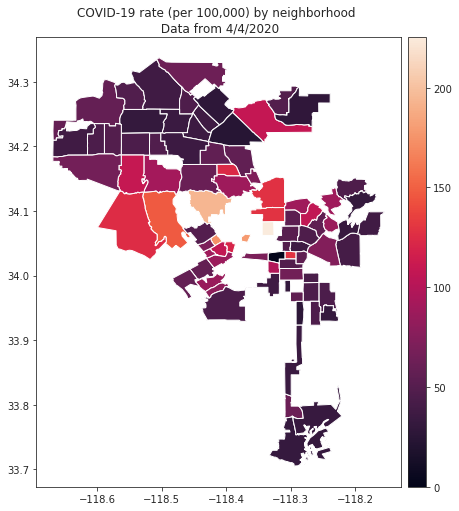

In [137]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
#sns.set_style('darkgrid')
#fig, ax = plt.subplots()
#rcParams['figure.figsize'] = 11.7,8.27

fig, ax = plt.subplots(1, 1)
plt.title('COVID-19 rate (per 100,000) by neighborhood \n Data from 4/4/2020')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdfNew.plot(column='rate', ax=ax, legend=True, cax=cax)

In [138]:
gdfNew.to_file(driver = 'ESRI Shapefile', filename= 'nghbrhddata.shp')

In [139]:
#pip install contextily